# LSTM: Sectionals_v3

Train an LSTM to analyze a horse’s past performance sequence and predict the horse's race pattern that reflects its projected strength today.

### Target is distance_back

✅ This model, unless it proves predictive on a standalone apactity, will be fed into the CatBoost/YetiRank model as a feature.

⸻

🔍 How Accurate is Ranking by Sectional Data Alone?

🔥 The Good:

If your LSTM is trained on well-normalized, consistent historical speed signals: • Relative ordering can be quite meaningful • Especially in smaller fields or when you’re identifying top 3–4 finishers • Even if absolute values are off, ranking is often more robust

❄️ The Limitations: • LSTM alone won’t account for today’s track conditions, surface bias, jockey/trainer changes, distance, class jump/drop • It may favor horses that ran fast recently but are now outclassed or mispositioned

In [1]:
# Setup Environment
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "0"
os.environ.pop("CUDA_VISIBLE_DEVICES", None)

# Setup Environment
import time
from optuna.importance import MeanDecreaseImpurityImportanceEvaluator
import os
import logging
import copy
import datetime
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import joblib
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import Dataset, DataLoader
import optuna
from torch.optim.lr_scheduler import OneCycleLR, StepLR
import torch.nn as nn
import numpy as np
import optuna.visualization as viz
import pyspark.sql.functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import (to_date, date_format, lpad, concat_ws, collect_list, struct, 
                                   col, count, row_number, abs, unix_timestamp, mean, 
                                   when, lit, min as F_min, max as F_max , upper, trim,
                                   mean as F_mean, countDistinct, last, first, when)
from src.data_preprocessing.data_prep1.data_utils import initialize_environment
from src.data_preprocessing.data_prep1.data_loader import load_data_from_postgresql

In [3]:
spark, jdbc_url, jdbc_properties, parquet_dir, log_file = initialize_environment()

Spark session created successfully.


In [4]:
def gps_sql_queries():
    queries = {
#         "gps_horse": """
#             SELECT g.course_cd, g.race_date,g.race_number,
#             REGEXP_REPLACE(TRIM(UPPER(saddle_cloth_number)), '\s+$', '') AS saddle_cloth_number, time_stamp, 
#             longitude, latitude, speed, progress, stride_frequency, g.post_time, location,
#             re.axciskey, h.horse_id, re.official_fin, h.horse_name
#             FROM gpspoint g
#             JOIN results_entries re on g.course_cd = re.course_cd
#                 AND g.race_date = re.race_date
#                 AND g.race_number = re.race_number
#                 AND g.saddle_cloth_number = re.program_num
#             JOIN horse h on re.axciskey = h.axciskey
#             WHERE speed is not null
#             AND progress is not null
#             AND stride_frequency is not null
#             """,
        "sectionals": """
            SELECT s.course_cd, s.race_date, s.race_number, h.horse_id, 
            REGEXP_REPLACE(TRIM(UPPER(saddle_cloth_number)), '\s+$', '') AS saddle_cloth_number, 
            s.gate_name, s.gate_numeric, s.length_to_finish, s.sectional_time, s.running_time, 
            s.distance_back, s.distance_ran, s.number_of_strides, s.post_time, re.official_fin
            FROM sectionals s
            JOIN results_entries re on s.course_cd = re.course_cd
                AND s.race_date = re.race_date
                AND s.race_number = re.race_number
                AND s.saddle_cloth_number = re.program_num
            JOIN horse h on re.axciskey = h.axciskey 
            WHERE length_to_finish is not null
            AND sectional_time is not null
            AND running_time is not null
            AND distance_back is not null
            AND distance_ran is not null
            AND distance_ran is not null
            AND number_of_strides is not null
            """
    }
    return queries


In [5]:
queries = gps_sql_queries()
dfs = load_data_from_postgresql(spark, jdbc_url, jdbc_properties, queries, parquet_dir)
        # Suppose we have a dictionary of queries
for name, df in dfs.items():
    logging.info(f"DataFrame '{name}' loaded. Schema:")
    df.printSchema()
    if name == "gps_horse":
        gps_horse_df = df
    elif name == "sectionals":
        sectionals_df = df    
    else:
        logging.error(f"Unknown DataFrame name: {name}")
        continue


root
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- horse_id: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- gate_name: string (nullable = true)
 |-- gate_numeric: double (nullable = true)
 |-- length_to_finish: double (nullable = true)
 |-- sectional_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- distance_back: double (nullable = true)
 |-- distance_ran: double (nullable = true)
 |-- number_of_strides: double (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- official_fin: integer (nullable = true)



In [6]:

start_time = time.time()
# # gps_horse_df.write.mode("overwrite").parquet(f"{parquet_dir}/gps_horse_df")
sectionals_df.write.mode("overwrite").parquet(f"{parquet_dir}/sectionals_df")
logging.info(f"Data written to Parquet in {time.time() - start_time:.2f} seconds")
    

In [7]:
# gps_horse_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/gps_horse_df")
sectionals_df = spark.read.parquet("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/parquet/sectionals_df")


In [8]:
sectionals_df.count()

5011852

## Create race_id

In [9]:
# Convert race_date to a proper date format
sectionals_df = sectionals_df.withColumn("race_date", to_date(col("race_date")))

# Construct a unique race_id using course_cd, race_date, and race_number
sectionals_df = sectionals_df.withColumn(
    "race_id",
    concat_ws(
        "_",
        col("course_cd"),
        date_format(col("race_date"), "yyyyMMdd"),
        lpad(col("race_number").cast("string"), 2, "0")
    )
)


## Create gate_seq_num Column

### 1) Cast gate_numeric to a Numeric Type

In [10]:
# For example, cast gate_numeric to double:
sectionals_df = sectionals_df.withColumn("gate_numeric", col("gate_numeric").cast("double"))

# Then (re)do your steps with the numeric column

In [11]:

# Step 1: Filter out finish rows to compute max gate_numeric per race
non_finish_df = sectionals_df.filter(F.col("gate_name") != "finish")

# Define a window partitioning by race identifiers
race_window = Window.partitionBy("course_cd", "race_date", "race_number")

# Compute maximum gate_numeric for each race (ignoring finish rows)
max_gate_df = non_finish_df.groupBy("course_cd", "race_date", "race_number") \
    .agg(F.max("gate_numeric").alias("max_gate_numeric"))

# Step 2: Join the maximum gate value back to the original DataFrame
joined_df = sectionals_df.join(max_gate_df, on=["course_cd", "race_date", "race_number"], how="left")

# Step 3: Create the new column 'gate_seq_num'
# If the gate is 'finish', assign max_gate_numeric + 0.5, else keep gate_numeric.
sectionals_df = joined_df.withColumn(
    "gate_seq_num",
    F.when(F.col("gate_name") == "finish", F.col("max_gate_numeric") + F.lit(0.5))
     .otherwise(F.col("gate_numeric"))
)

## Sort

In [12]:
sectionals_df.select("saddle_cloth_number", "gate_name", "gate_seq_num", "running_time") \
  .filter("race_id = 'TGP_20240818_09' AND saddle_cloth_number = 3") \
  .orderBy(F.asc("gate_seq_num")) \
  .show(50, truncate=False)

+-------------------+---------+------------+------------+
|saddle_cloth_number|gate_name|gate_seq_num|running_time|
+-------------------+---------+------------+------------+
|3                  |0.32f    |0.32        |97.868      |
|3                  |0.82f    |0.82        |91.295      |
|3                  |1.32f    |1.32        |84.886      |
|3                  |1.82f    |1.82        |78.442      |
|3                  |2.32f    |2.32        |71.884      |
|3                  |2.82f    |2.82        |65.485      |
|3                  |3.32f    |3.32        |59.242      |
|3                  |3.82f    |3.82        |53.334      |
|3                  |4.32f    |4.32        |47.578      |
|3                  |4.82f    |4.82        |41.847      |
|3                  |5.32f    |5.32        |36.056      |
|3                  |5.82f    |5.82        |30.109      |
|3                  |6.32f    |6.32        |24.409      |
|3                  |6.82f    |6.82        |18.789      |
|3            

## Extract the Final Distance for Each Horse

In [13]:

# A) Filter just the finish rows
finish_df = sectionals_df.filter(F.col("gate_name") == "finish")

# B) Select the final distance for that horse
#    We'll rename it to "final_dist" to avoid conflict
finish_dist_df = finish_df.select(
    "race_id",
    "horse_id",
    F.col("distance_back").alias("final_dist")
)

## Join This Final Distance Back to All Rows

In [14]:
# Join on (race_id, horse_id) so every row for that horse
# gets the final distance, if it exists.
with_final_dist = sectionals_df.join(
    finish_dist_df,
    on=["race_id", "horse_id"],
    how="left"
)

## Filter Out the Finish Row

In [15]:
partial_only_df = with_final_dist.filter(F.col("gate_name") != "finish")

## Rename final_dist to target

In [16]:
partial_only_df = partial_only_df.withColumnRenamed("final_dist", "target")

In [17]:
sectionals_df = partial_only_df

sectionals_df.printSchema()

root
 |-- race_id: string (nullable = false)
 |-- horse_id: integer (nullable = true)
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- gate_name: string (nullable = true)
 |-- gate_numeric: double (nullable = true)
 |-- length_to_finish: double (nullable = true)
 |-- sectional_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- distance_back: double (nullable = true)
 |-- distance_ran: double (nullable = true)
 |-- number_of_strides: double (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- max_gate_numeric: double (nullable = true)
 |-- gate_seq_num: double (nullable = true)
 |-- target: double (nullable = true)



In [18]:
# PySpark query to filter and select specific columns
filtered_sectionals_df = sectionals_df.filter(col("race_id") == "TGP_20240818_09") \
    .select("course_cd", "race_date", "race_number", "saddle_cloth_number").distinct()

# Show the result
filtered_sectionals_df.show()

+---------+----------+-----------+-------------------+
|course_cd| race_date|race_number|saddle_cloth_number|
+---------+----------+-----------+-------------------+
|      TGP|2024-08-18|          9|                  4|
|      TGP|2024-08-18|          9|                  7|
|      TGP|2024-08-18|          9|                  3|
|      TGP|2024-08-18|          9|                  6|
|      TGP|2024-08-18|          9|                  5|
+---------+----------+-----------+-------------------+



In [19]:
# from pyspark.sql import functions as F

# # 1) First, get a DataFrame mapping each race_id to the unique horse count.
# horses_per_race_df = (
#     sectionals_df
#     .groupBy("race_id")
#     .agg(F.countDistinct("horse_id").alias("num_horses"))
# )

# # 2) Now group *that* result by num_horses to see how many races have that count.
# dist_df = (
#     horses_per_race_df
#     .groupBy("num_horses")
#     .count()
#     .orderBy("num_horses")
# )
# dist_df.show()

In [20]:
# # PySpark query to filter and select specific columns
# filtered_sectionals_df = sectionals_df.filter(col("race_id") == "TGP_20240818_09") \
#     .select("course_cd", "race_date", "race_number", "saddle_cloth_number").distinct()

# # Show the result
# filtered_sectionals_df.show()

In [21]:
# # Step 1: create a DataFrame of only the races that have >=4 horses
# valid_races_df = (
#     horses_per_race_df
#     .filter(F.col("num_horses") >= 4)
#     .select("race_id")
#     .distinct()
# )

# # Step 2: Join the original data with valid_races_df to keep only those race_ids
# sectionals_df = sectionals_df.join(valid_races_df, on="race_id", how="inner")


# Compute Sequence Lenghts

### Filter Rows with >=1 and <=38 Sequences

In [24]:

# Step 1: Compute sequence lengths per horse per race
df_seq_len = sectionals_df.groupBy("race_id", "horse_id").agg(F.count("*").alias("seq_length"))

# Step 2: Filter sequences with length between 1 and 38
filtered_df = df_seq_len.filter((F.col("seq_length") >= 1) & (F.col("seq_length") <= 38))

# Step 3: Join the filtered sequence lengths back with the original data
sectionals_df = sectionals_df.join(filtered_df, on=["race_id", "horse_id"], how="inner")

### Plot Sequence Lengths

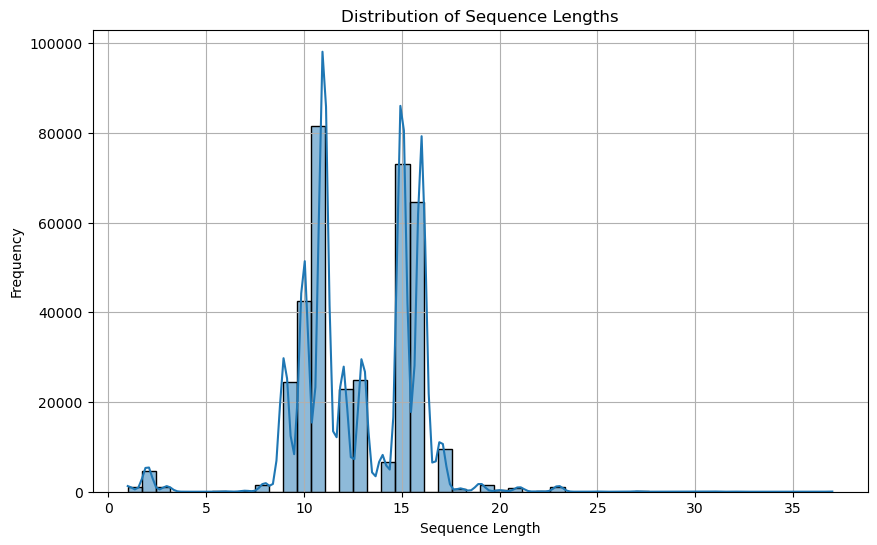

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_seq_len is a DataFrame with a 'seq_length' column
# If df_seq_len is a PySpark DataFrame, convert it to Pandas
df_seq_len_pd = df_seq_len.toPandas()

# Plotting the histogram
plt.figure(figsize=(10, 6))
sns.histplot(df_seq_len_pd['seq_length'], bins=50, kde=True)
plt.title('Distribution of Sequence Lengths')
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

## Padding Sequences to a Fixed Length

###  Step 1: Convert to Sequence Format

In [26]:
sectionals_df.printSchema()

root
 |-- race_id: string (nullable = false)
 |-- horse_id: integer (nullable = true)
 |-- course_cd: string (nullable = true)
 |-- race_date: date (nullable = true)
 |-- race_number: integer (nullable = true)
 |-- saddle_cloth_number: string (nullable = true)
 |-- gate_name: string (nullable = true)
 |-- gate_numeric: double (nullable = true)
 |-- length_to_finish: double (nullable = true)
 |-- sectional_time: double (nullable = true)
 |-- running_time: double (nullable = true)
 |-- distance_back: double (nullable = true)
 |-- distance_ran: double (nullable = true)
 |-- number_of_strides: double (nullable = true)
 |-- post_time: timestamp (nullable = true)
 |-- official_fin: integer (nullable = true)
 |-- max_gate_numeric: double (nullable = true)
 |-- gate_seq_num: double (nullable = true)
 |-- target: double (nullable = true)
 |-- seq_length: long (nullable = false)
 |-- seq_length: long (nullable = false)



## Create segment_ordinal

In [27]:
from pyspark.sql.window import Window
import pyspark.sql.functions as F

w = Window.partitionBy("race_id", "horse_id").orderBy(F.asc("gate_seq_num"))

sectionals_df = sectionals_df.withColumn(
    "segment_ordinal",
    F.row_number().over(w)   # 1-based index for each call in ascending order
)

## Make Sequences

In [28]:
features = [
    "length_to_finish",
    "sectional_time",
    "running_time",
    "distance_back",
    "distance_ran",
    "number_of_strides"
]

In [29]:
from pyspark.sql.functions import struct, collect_list

df_features = sectionals_df.select(
    "race_id",
    "horse_id",
    "segment_ordinal",
    F.struct(*[F.col(f) for f in features]).alias("feature_struct")
)

# Window to collect all rows (time steps) for each (race_id, horse_id).
collect_w = Window.partitionBy("race_id", "horse_id").orderBy("segment_ordinal") \
                  .rowsBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df_features = df_features.withColumn(
    "sequence",
    collect_list("feature_struct").over(collect_w)
)

# Now each row for that horse has a "sequence", but repeated for each time step.
# We only want the final row for each horse, i.e. the row with max(segment_ordinal).
df_features = df_features.withColumn(
    "rn",
    F.row_number().over(
        Window.partitionBy("race_id", "horse_id").orderBy(F.desc("segment_ordinal"))
    )
)

# Keep only rn == 1 (the row with the largest segment_ordinal => entire sequence):
df_features = df_features.filter(F.col("rn") == 1)

# Now df_features has columns: [race_id, horse_id, sequence], one row per horse.
df_features = df_features.select("race_id", "horse_id", "sequence")

In [30]:
df_features = df_features.join(
    sectionals_df
        .select("race_id", "horse_id", "target")
        .dropDuplicates(["race_id", "horse_id"]), 
    on=["race_id", "horse_id"],
    how="left"
)

In [31]:
from pyspark.sql.types import ArrayType, StructType, StructField, FloatType

# We must define the schema for the array of structs that we store in "sequence".
# If you have 6 float features, define them accordingly. For example:
feature_struct_schema = StructType([
    StructField("length_to_finish", FloatType(), True),
    StructField("sectional_time", FloatType(), True),
    StructField("running_time", FloatType(), True),
    StructField("distance_back", FloatType(), True),
    StructField("distance_ran", FloatType(), True),
    StructField("number_of_strides", FloatType(), True)
])

target_len = 38

# Python function to pad/truncate a list of structs:
def pad_sequence(seq, max_len=target_len):
    """Truncates if len(seq)>max_len, else pads with zero-like structs."""
    if seq is None:
        return []
    
    seq = list(seq)  # ensure it's mutable

    # 1) Truncate if too long
    if len(seq) > max_len:
        seq = seq[:max_len]

    # 2) Pad if too short
    while len(seq) < max_len:
        seq.append({
            "length_to_finish": 0.0,
            "sectional_time": 0.0,
            "running_time": 0.0,
            "distance_back": 0.0,
            "distance_ran": 0.0,
            "number_of_strides": 0.0
        })
    return seq

pad_sequence_udf = F.udf(lambda seq: pad_sequence(seq, target_len), 
                         ArrayType(feature_struct_schema))

df_features = df_features.withColumn(
    "padded_sequence", 
    pad_sequence_udf("sequence")
)

In [32]:
df_features.columns

['race_id', 'horse_id', 'sequence', 'target', 'padded_sequence']

### Convert to Pandas

In [33]:
all_pd = df_features.toPandas()

# Sort by race_date to maintain temporal order
all_pd = all_pd.sort_values("race_id").reset_index(drop=True)

### Drop NaN target

In [34]:
# Number of rows before
old_count = len(all_pd)

# Drop rows where "target" is NaN
all_pd = all_pd.dropna(subset=["target"])

# Number of rows after
new_count = len(all_pd)

print(f"Rows before drop: {old_count}, after drop: {new_count}")
print(f"Rows dropped: {old_count - new_count}")

Rows before drop: 363384, after drop: 363202
Rows dropped: 182


# Split & Normalize

## Split by Entire Race 

In [35]:
import numpy as np
import pandas as pd

def prepare_data_3way_split_by_race(
    df,
    race_date_col=None,
    train_frac=0.70,
    val_frac=0.15,
    test_frac=0.15,
    target_len=38
):
    """
    Splits the entire dataset into (train, val, test) by race_id so that
    all horses in a race go to the same split. Then, for each subset,
    we build X arrays of shape (num_samples, target_len, 6) [or #features],
    y arrays of shape (num_samples,), and we keep an array of race_ids as well.

    Returns:
      (X_train, y_train, race_ids_train,
       X_val,   y_val,   race_ids_val,
       X_test,  y_test,  race_ids_test)
    """

    # -----------------------------
    # (A) Sort the race_ids
    # -----------------------------
    #  If you have a race_date column, use it to sort the races in chronological order
    if race_date_col and race_date_col in df.columns:
        # Make sure race_date_col is a date or something sortable
        # Then collect unique (race_id, race_date), sort by race_date
        race_date_map = (
            df[[race_date_col, "race_id"]]
            .drop_duplicates(subset=["race_id"])
            .sort_values(by=race_date_col)
        )
        race_ids_sorted = race_date_map["race_id"].tolist()
    else:
        # If no date, lexicographically sort the unique race_ids
        race_ids_sorted = sorted(df["race_id"].unique())

    n_races = len(race_ids_sorted)
    n_train = int(train_frac * n_races)
    n_val   = int(val_frac   * n_races)
    # remainder goes to test
    n_test  = n_races - (n_train + n_val)

    # slice them
    train_races = race_ids_sorted[:n_train]
    val_races   = race_ids_sorted[n_train : n_train + n_val]
    test_races  = race_ids_sorted[n_train + n_val : ]

    # -----------------------------
    # (B) Filter the main df
    # -----------------------------
    df_train = df[df["race_id"].isin(train_races)].copy()
    df_val   = df[df["race_id"].isin(val_races)].copy()
    df_test  = df[df["race_id"].isin(test_races)].copy()

    # Optionally ensure no duplicates
    df_train = df_train.drop_duplicates(subset=["race_id", "horse_id"])
    df_val   = df_val.drop_duplicates(subset=["race_id", "horse_id"])
    df_test  = df_test.drop_duplicates(subset=["race_id", "horse_id"])

    # -----------------------------
    # (C) Build arrays (X, y, race_ids) for each subset
    # -----------------------------

    def build_lstm_arrays(sub_df, target_len):
        X_list = []
        y_list = []
        rid_list = []
        hid_list = []
        
        for _, row in sub_df.iterrows():
            # This is already a list of exactly 'target_len' dicts
            seq_data = row["padded_sequence"]  

            # Convert each dict in seq_data into a numeric [6]-list
            numeric_seq = []
            for d in seq_data:
                numeric_seq.append([
                    d["length_to_finish"],
                    d["sectional_time"],
                    d["running_time"],
                    d["distance_back"],
                    d["distance_ran"],
                    d["number_of_strides"]
                ])

            X_list.append(numeric_seq)
            y_list.append(row["target"])   # or row["target"], if that’s your label
            rid_list.append(row["race_id"])
            hid_list.append(row["horse_id"])
            
        X_array = np.array(X_list, dtype=np.float32)
        y_array = np.array(y_list, dtype=np.float32)
        r_array = np.array(rid_list)
        h_array = np.array(hid_list, dtype=np.int64)
        
        return X_array, y_array, r_array, h_array

    # do it for each
    X_train, y_train, raceids_train, horseids_train = build_lstm_arrays(df_train, target_len)
    X_val,   y_val,   raceids_val,   horseids_val   = build_lstm_arrays(df_val,   target_len)
    X_test,  y_test,  raceids_test,  horseids_test  = build_lstm_arrays(df_test,  target_len)

    return (
        X_train, y_train, raceids_train, horseids_train,
        X_val,   y_val,   raceids_val,   horseids_val,
        X_test,  y_test,  raceids_test,  horseids_test
    )

## Define Helper Functions

In [36]:
class SingleHorseDataset(Dataset):
    def __init__(self, X_array, y_array):
        """
        X_array: shape (N, seq_len, num_features)
        y_array: shape (N,)
        """
        self.X_array = X_array
        self.y_array = y_array

    def __len__(self):
        return len(self.X_array)

    def __getitem__(self, idx):
        X = self.X_array[idx]  # (seq_len, num_features)
        y = self.y_array[idx]  # scalar
        # Convert to tensors
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32)
        return X_tensor, y_tensor


# SAVE YOUR SCALERS NEXT TIME

In [37]:
def prepare_SingleHorse_data(
    X_train, y_train, race_ids_train,
    X_val,   y_val,   race_ids_val,
    X_test,  y_test,  race_ids_test,
):
    """
    1) Caps outliers (1st/99th percentile).
    2) MinMax-scales features.
    3) Builds three SingleHorseDatasets & DataLoaders (train, val, test).
    """

    def cap_outliers(data, lower=1, upper=99):
        lo = np.percentile(data, lower, axis=0)
        hi = np.percentile(data, upper, axis=0)
        return np.clip(data, lo, hi)
    
    # --- Training set ---
    num_train, seq_len, num_features = X_train.shape
    X_train_flat = X_train.reshape(-1, num_features)
    X_train_cap = cap_outliers(X_train_flat)
    scaler_X = MinMaxScaler()
    X_train_scaled_flat = scaler_X.fit_transform(X_train_cap)
    X_train_scaled = X_train_scaled_flat.reshape(num_train, seq_len, num_features)
    
    # --- Validation set ---
    num_val, seq_len_val, num_features_val = X_val.shape
    X_val_flat = X_val.reshape(-1, num_features_val)
    X_val_cap = cap_outliers(X_val_flat)
    X_val_scaled_flat = scaler_X.transform(X_val_cap)
    X_val_scaled = X_val_scaled_flat.reshape(num_val, seq_len_val, num_features_val)
    
    # --- Test set ---
    num_test, seq_len_test, num_features_test = X_test.shape
    X_test_flat = X_test.reshape(-1, num_features_test)
    X_test_cap = cap_outliers(X_test_flat)
    X_test_scaled_flat = scaler_X.transform(X_test_cap)
    X_test_scaled = X_test_scaled_flat.reshape(num_test, seq_len_test, num_features_test)
    
    ####################################
    # 1) CAP + SCALE FOR Y_TRAIN
    ####################################
    y_train_unscaled = y_train
    # Reshape to 2D so scaler can work on columns
    y_train_2d = y_train.reshape(-1, 1)

    # Cap outliers
    y_train_cap = cap_outliers(y_train_2d)

    # Fit a separate scaler for the labels
    scaler_y = MinMaxScaler()
    y_train_scaled_2d = scaler_y.fit_transform(y_train_cap)

    # Flatten back to 1D
    y_train_scaled = y_train_scaled_2d.flatten()

    ####################################
    # 2) CAP + SCALE FOR Y_VAL
    ####################################
    y_val_2d = y_val.reshape(-1, 1)
    y_val_cap = cap_outliers(y_val_2d)
    y_val_scaled_2d = scaler_y.transform(y_val_cap)
    y_val_scaled = y_val_scaled_2d.flatten()

    ####################################
    # 3) CAP + SCALE FOR Y_TEST
    ####################################
    y_test_2d = y_test.reshape(-1, 1)
    y_test_cap = cap_outliers(y_test_2d)
    y_test_scaled_2d = scaler_y.transform(y_test_cap)
    y_test_scaled = y_test_scaled_2d.flatten()
    
    ####################################
    # 4) Save Scalers
    ####################################
    save_dir="/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_sectionals"
    try:
        os.makedirs(save_dir, exist_ok=True)
        joblib.dump(scaler_X, os.path.join(save_dir, "scaler_X.pkl"))
        joblib.dump(scaler_y, os.path.join(save_dir, "scaler_y.pkl"))
        print(f"Scalers saved to {save_dir!r}")
    except Exception as e:
        print(f"Failed to save scalers: {e!r}")

    # Build the SingleHorseDatasets
    train_dataset = SingleHorseDataset(X_train_scaled, y_train_scaled)
    val_dataset   = SingleHorseDataset(X_val_scaled,   y_val_scaled)
    test_dataset  = SingleHorseDataset(X_test_scaled,  y_test_scaled)

    # Build DataLoaders (you can pick any batch_size > 1)
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_dataset,   batch_size=16, shuffle=False)
    test_loader  = DataLoader(test_dataset,  batch_size=16, shuffle=False)

    return (
        X_train_scaled, y_train_scaled, y_train_unscaled, scaler_X, scaler_y,
        X_val_scaled,   y_val_scaled,
        X_test_scaled,  y_test_scaled,
        scaler_X,       scaler_y,  
        train_dataset,  val_dataset,     test_dataset,
        train_loader,   val_loader,     test_loader
    )

In [38]:
(X_train, y_train, raceids_train, horseids_train,
 X_val,   y_val,   raceids_val,   horseids_val,
 X_test,  y_test,  raceids_test,  horseids_test
)= prepare_data_3way_split_by_race(
    df=all_pd, 
    race_date_col="race_date",  # or None if you want lexicographic
    train_frac=0.70,
    val_frac=0.15,
    test_frac=0.15,
    target_len=38
)


In [39]:
(
    X_train_scaled, y_train_scaled, y_train_unscaled, scaler_x, scaler_y,
    X_val_scaled,   y_val_scaled,
    X_test_scaled,  y_test_scaled,
    scaler_X, scaler_y,
    train_dataset, val_dataset, test_dataset,
    train_loader, val_loader, test_loader
) = prepare_SingleHorse_data(
    X_train, y_train, raceids_train,
    X_val,   y_val,   raceids_val,
    X_test,  y_test,  raceids_test
)

print("Train loader has", len(train_loader), "batches.")
print("Val loader has", len(val_loader), "batches.")
print("Test loader has", len(test_loader), "batches.")

Scalers saved to '/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/training_scalers_sectionals'
Train loader has 15459 batches.
Val loader has 3616 batches.
Test loader has 3627 batches.


# 🧠 Basic LSTM Model for Sequence Classification

In [40]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device name 0:", torch.cuda.get_device_name(0))

CUDA available: True
CUDA device count: 2
Device name 0: NVIDIA RTX A6000


In [41]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Train a Simple LSTM Regression Model

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HorseTimeSeriesLSTM(nn.Module):
    def __init__(
        self,
        input_size: int = 6,
        hidden_size: int = 64,
        embedding_size: int = 16,
        dropout: float = 0.0,
        num_layers: int = 1       # ← new parameter with default
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,  # ← pass it here
            batch_first=True
        )
        self.dropout   = nn.Dropout(dropout)
        self.head      = nn.Linear(hidden_size, 1)
        self.projection = nn.Linear(hidden_size, embedding_size)

    def forward(self, x):
        """
        x: (batch_size, seq_len, input_size)
        Returns:
          pred => (batch_size,) numeric regression output
          embed => (batch_size, embedding_size)
        """
        out, (h_n, c_n) = self.lstm(x)
        last_hidden    = out[:, -1, :]
        last_hidden    = self.dropout(last_hidden)
        pred           = self.head(last_hidden).squeeze(1)
        embed          = self.projection(last_hidden)
        return pred, embed

### 🧪 Mini Training Loop

In [53]:
from tqdm.notebook import tqdm
###############################################################################
# Training Loop for One Epoch
###############################################################################
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    num_batches = 0

    for X_batch, y_batch in tqdm(loader, desc="Training", leave=False):
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        pred, embed = model(X_batch)
        loss = F.mse_loss(pred, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        num_batches += 1

    return total_loss / num_batches if num_batches > 0 else 0.0

In [54]:
###############################################################################
# Evaluation Loop
###############################################################################
def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)

            pred, embed = model(X_batch)
            loss = F.mse_loss(pred, y_batch)

            total_loss += loss.item()
            num_batches += 1

    return total_loss / num_batches if num_batches > 0 else 0.0

In [55]:
import torch
print("CUDA available:", torch.cuda.is_available())
print("CUDA device count:", torch.cuda.device_count())
print("Device 0:", torch.cuda.get_device_name(0))
if torch.cuda.device_count() > 1:
    print("Device 1:", torch.cuda.get_device_name(1))

CUDA available: True
CUDA device count: 2
Device 0: NVIDIA RTX A6000
Device 1: NVIDIA RTX A6000


In [59]:
import copy
import optuna
import torch
from torch.utils.data import DataLoader


def objective(trial):
    import torch.optim as optim

    # If you want to pick a specific GPU, or see how many you have
    gpu_count = torch.cuda.device_count()
    print("GPU Count:", gpu_count)
    device = torch.device("cuda" if gpu_count > 0 else "cpu")

    # 1) Hyperparams from Optuna
    lr = trial.suggest_float("lr", 1e-5, 5e-3, log=True)  # e.g. between 5e-4 and 5e-3
    hidden_size = trial.suggest_categorical("hidden_size", [32, 64, 128, 256])
    dropout = trial.suggest_float("dropout", 0.47, 0.9)
    num_layers = trial.suggest_int("num_layers", 1, 4)

    # 2) Build the single-horse LSTM
    model = HorseTimeSeriesLSTM(
        input_size=6,
        hidden_size=hidden_size,
        embedding_size=16,  # fixed
        dropout=dropout,
        num_layers=num_layers
    )

    # Optionally wrap in DataParallel if >1 GPU
    # Note: This requires batch_size > 1 if we want to see a speedup across GPUs.
    if gpu_count > 1:
        model = nn.DataParallel(model)

    # Move model to device
    model.to(device)

    # 3) Optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # 4) DataLoaders (single-horse datasets)
    #    Make sure these have batch_size > 1 if you want multi-GPU usage to help.
    #    For example, batch_size=16 or 32.
    batch_size = 128
    train_loader = DataLoader(
                    train_dataset,
                    batch_size=batch_size, 
                    shuffle=True,
                    num_workers=32,     # or 8, or more
                    pin_memory=True    # often helps on GPU
                )
    train_loader = DataLoader(
                    train_dataset,
                    batch_size=batch_size, 
                    shuffle=True,
                    num_workers=32,     # or 8, or more
                    pin_memory=True    # often helps on GPU
                )
    # 5) Early Stopping Setup
    best_val_loss = float('inf')
    best_model_state = copy.deepcopy(model.state_dict())
    patience = 5
    epochs_without_improvement = 0
    num_epochs = 50

    # 6) Main Training Loop
    for epoch in range(num_epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_loss   = evaluate(model, val_loader, device)

        print(f"[Epoch {epoch+1}/{num_epochs}] train_loss={train_loss:.4f}, val_loss={val_loss:.4f}")

        # Early stopping check
        if val_loss < best_val_loss - 1e-5:
            best_val_loss = val_loss
            best_model_state = copy.deepcopy(model.state_dict())
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        # Optuna pruning
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 7) Load best model state and return best_val_loss
    model.load_state_dict(best_model_state)
    return best_val_loss

In [60]:
# Function to run the Optuna study with SQLite database persistence
def run_optuna(n_trials=100):
    # Create a study with SQLite storage; it will load the study if it already exists
    study = optuna.create_study(
        study_name="horse_race_study_v1",
        storage="sqlite:///optuna_sec_lstm.db",
        direction="minimize",
        load_if_exists=True
    )
    
    # Optimize the objective function
    study.optimize(objective, n_trials=n_trials)
    
    # Print the best trial's details
    print("Best trial:")
    best_trial = study.best_trial
    print("  Validation Loss:", best_trial.value)
    print("  Best hyperparameters:")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")
    
    return study

In [61]:
# Run Optuna tuning
study = run_optuna(n_trials=100)

[I 2025-04-25 22:53:29,617] A new study created in RDB with name: horse_race_study_v1


GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0415, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0146, val_loss=0.0057


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0066, val_loss=0.0049


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 4/50] train_loss=0.0056, val_loss=0.0049


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 5/50] train_loss=0.0047, val_loss=0.0035


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 6/50] train_loss=0.0043, val_loss=0.0033


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 7/50] train_loss=0.0040, val_loss=0.0036


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 8/50] train_loss=0.0039, val_loss=0.0031


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 9/50] train_loss=0.0038, val_loss=0.0029


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 10/50] train_loss=0.0038, val_loss=0.0028


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 11/50] train_loss=0.0038, val_loss=0.0031


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 12/50] train_loss=0.0037, val_loss=0.0034


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 13/50] train_loss=0.0037, val_loss=0.0026


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 14/50] train_loss=0.0037, val_loss=0.0031


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 15/50] train_loss=0.0036, val_loss=0.0026


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 16/50] train_loss=0.0036, val_loss=0.0029


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 17/50] train_loss=0.0036, val_loss=0.0028


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 18/50] train_loss=0.0035, val_loss=0.0035


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 19/50] train_loss=0.0035, val_loss=0.0033


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:01:50,042] Trial 0 finished with value: 0.002595738316988425 and parameters: {'lr': 0.0002208924190280613, 'hidden_size': 256, 'dropout': 0.8248806713946641, 'num_layers': 3}. Best is trial 0 with value: 0.002595738316988425.


[Epoch 20/50] train_loss=0.0034, val_loss=0.0026
Early stopping at epoch 20
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0410, val_loss=0.0427


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0428


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 4/50] train_loss=0.0405, val_loss=0.0427


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 5/50] train_loss=0.0406, val_loss=0.0427


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 6/50] train_loss=0.0406, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 7/50] train_loss=0.0406, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:04:29,300] Trial 1 finished with value: 0.042583774865411254 and parameters: {'lr': 0.0012608859508268756, 'hidden_size': 32, 'dropout': 0.8415939734673025, 'num_layers': 3}. Best is trial 0 with value: 0.002595738316988425.


[Epoch 8/50] train_loss=0.0406, val_loss=0.0426
Early stopping at epoch 8
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0408, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0427


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 4/50] train_loss=0.0406, val_loss=0.0427


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 5/50] train_loss=0.0159, val_loss=0.0054


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 6/50] train_loss=0.0051, val_loss=0.0036


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 7/50] train_loss=0.0046, val_loss=0.0039


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 8/50] train_loss=0.0045, val_loss=0.0038


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 9/50] train_loss=0.0042, val_loss=0.0030


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 10/50] train_loss=0.0041, val_loss=0.0025


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 11/50] train_loss=0.0040, val_loss=0.0025


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 12/50] train_loss=0.0039, val_loss=0.0024


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 13/50] train_loss=0.0038, val_loss=0.0024


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 14/50] train_loss=0.0038, val_loss=0.0026


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 15/50] train_loss=0.0037, val_loss=0.0029


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 16/50] train_loss=0.0037, val_loss=0.0036


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:09:24,561] Trial 2 finished with value: 0.0024147840222031743 and parameters: {'lr': 0.0010268597807203026, 'hidden_size': 128, 'dropout': 0.7762334478740744, 'num_layers': 1}. Best is trial 2 with value: 0.0024147840222031743.


[Epoch 17/50] train_loss=0.0036, val_loss=0.0032
Early stopping at epoch 17
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0421, val_loss=0.0429


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0408, val_loss=0.0427


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0427


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 4/50] train_loss=0.0232, val_loss=0.0056


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 5/50] train_loss=0.0079, val_loss=0.0050


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 6/50] train_loss=0.0070, val_loss=0.0043


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 7/50] train_loss=0.0066, val_loss=0.0041


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 8/50] train_loss=0.0063, val_loss=0.0042


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 9/50] train_loss=0.0062, val_loss=0.0040


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 10/50] train_loss=0.0061, val_loss=0.0034


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 11/50] train_loss=0.0059, val_loss=0.0034


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 12/50] train_loss=0.0058, val_loss=0.0031


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 13/50] train_loss=0.0057, val_loss=0.0035


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 14/50] train_loss=0.0057, val_loss=0.0031


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 15/50] train_loss=0.0057, val_loss=0.0033


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 16/50] train_loss=0.0056, val_loss=0.0043


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:15:02,938] Trial 3 finished with value: 0.0030703493598754896 and parameters: {'lr': 0.0001826819434842119, 'hidden_size': 128, 'dropout': 0.8930962516591431, 'num_layers': 3}. Best is trial 2 with value: 0.0024147840222031743.


[Epoch 17/50] train_loss=0.0056, val_loss=0.0032
Early stopping at epoch 17
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0156, val_loss=0.0040


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0055, val_loss=0.0028


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0054, val_loss=0.0047


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 4/50] train_loss=0.0047, val_loss=0.0035


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 5/50] train_loss=0.0045, val_loss=0.0051


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 6/50] train_loss=0.0043, val_loss=0.0029


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:17:22,494] Trial 4 finished with value: 0.0028463888933788237 and parameters: {'lr': 0.0040584900956035, 'hidden_size': 128, 'dropout': 0.8100155538737114, 'num_layers': 3}. Best is trial 2 with value: 0.0024147840222031743.


[Epoch 7/50] train_loss=0.0041, val_loss=0.0034
Early stopping at epoch 7
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:17:44,531] Trial 5 pruned. 


[Epoch 1/50] train_loss=0.0411, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:18:05,896] Trial 6 pruned. 


[Epoch 1/50] train_loss=0.0439, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:18:31,204] Trial 7 pruned. 


[Epoch 1/50] train_loss=0.0410, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:18:49,821] Trial 8 pruned. 


[Epoch 1/50] train_loss=0.0412, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:19:12,029] Trial 9 pruned. 


[Epoch 1/50] train_loss=0.0412, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0408, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:20:22,011] Trial 10 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0429
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:20:39,621] Trial 11 pruned. 


[Epoch 1/50] train_loss=0.0410, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:21:07,659] Trial 12 pruned. 


[Epoch 1/50] train_loss=0.0410, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:21:25,340] Trial 13 pruned. 


[Epoch 1/50] train_loss=0.0436, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:21:47,614] Trial 14 pruned. 


[Epoch 1/50] train_loss=0.0410, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0410, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0428


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:22:53,562] Trial 15 pruned. 


[Epoch 3/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:23:10,722] Trial 16 pruned. 


[Epoch 1/50] train_loss=0.0764, val_loss=0.0471
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:23:28,963] Trial 17 pruned. 


[Epoch 1/50] train_loss=0.0430, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0409, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0407, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:24:44,650] Trial 18 pruned. 


[Epoch 3/50] train_loss=0.0406, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0408, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0428


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0406, val_loss=0.0427


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:26:14,122] Trial 19 pruned. 


[Epoch 4/50] train_loss=0.0406, val_loss=0.0429
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:26:32,947] Trial 20 pruned. 


[Epoch 1/50] train_loss=0.0409, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:26:53,009] Trial 21 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0407, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:27:52,519] Trial 22 pruned. 


[Epoch 3/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:28:12,117] Trial 23 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0408, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0406, val_loss=0.0427


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:29:07,290] Trial 24 pruned. 


[Epoch 3/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0408, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0096, val_loss=0.0049


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0047, val_loss=0.0043


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 4/50] train_loss=0.0042, val_loss=0.0034


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 5/50] train_loss=0.0040, val_loss=0.0025


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 6/50] train_loss=0.0039, val_loss=0.0040


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 7/50] train_loss=0.0038, val_loss=0.0032


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 8/50] train_loss=0.0037, val_loss=0.0045


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 9/50] train_loss=0.0256, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:32:26,162] Trial 25 finished with value: 0.002485163986945124 and parameters: {'lr': 0.002838746875099419, 'hidden_size': 128, 'dropout': 0.7343168769920381, 'num_layers': 3}. Best is trial 2 with value: 0.0024147840222031743.


[Epoch 10/50] train_loss=0.0147, val_loss=0.0028
Early stopping at epoch 10
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:32:47,533] Trial 26 pruned. 


[Epoch 1/50] train_loss=0.0411, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0407, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:33:24,039] Trial 27 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0412, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0237, val_loss=0.0062


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0055, val_loss=0.0047


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 4/50] train_loss=0.0051, val_loss=0.0035


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 5/50] train_loss=0.0046, val_loss=0.0030


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 6/50] train_loss=0.0043, val_loss=0.0031


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 7/50] train_loss=0.0041, val_loss=0.0028


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 8/50] train_loss=0.0040, val_loss=0.0026


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 9/50] train_loss=0.0038, val_loss=0.0031


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 10/50] train_loss=0.0038, val_loss=0.0039


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 11/50] train_loss=0.0037, val_loss=0.0027


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 12/50] train_loss=0.0037, val_loss=0.0026


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:37:43,000] Trial 28 finished with value: 0.002558692356981423 and parameters: {'lr': 0.001219457060231031, 'hidden_size': 128, 'dropout': 0.7279141624275084, 'num_layers': 3}. Best is trial 2 with value: 0.0024147840222031743.


[Epoch 13/50] train_loss=0.0036, val_loss=0.0027
Early stopping at epoch 13
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:38:03,093] Trial 29 pruned. 


[Epoch 1/50] train_loss=0.0412, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:38:23,008] Trial 30 pruned. 


[Epoch 1/50] train_loss=0.0410, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:38:42,745] Trial 31 pruned. 


[Epoch 1/50] train_loss=0.0410, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:39:02,918] Trial 32 pruned. 


[Epoch 1/50] train_loss=0.0409, val_loss=0.0429
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0408, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:39:43,500] Trial 33 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0409, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:40:28,395] Trial 34 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0430
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0407, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:41:07,605] Trial 35 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:41:29,479] Trial 36 pruned. 


[Epoch 1/50] train_loss=0.0413, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0408, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:42:09,680] Trial 37 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0410, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:43:00,014] Trial 38 pruned. 


[Epoch 2/50] train_loss=0.0173, val_loss=0.0077
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0353, val_loss=0.0070


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0086, val_loss=0.0038


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0076, val_loss=0.0047


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 4/50] train_loss=0.0074, val_loss=0.0032


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 5/50] train_loss=0.0071, val_loss=0.0047


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 6/50] train_loss=0.0071, val_loss=0.0034


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 7/50] train_loss=0.0070, val_loss=0.0042


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 8/50] train_loss=0.0068, val_loss=0.0041


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 9/50] train_loss=0.0068, val_loss=0.0030


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 10/50] train_loss=0.0067, val_loss=0.0034


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 11/50] train_loss=0.0066, val_loss=0.0028


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 12/50] train_loss=0.0066, val_loss=0.0040


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:47:00,538] Trial 39 pruned. 


[Epoch 13/50] train_loss=0.0064, val_loss=0.0028
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:47:22,943] Trial 40 pruned. 


[Epoch 1/50] train_loss=0.0409, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0410, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:48:02,592] Trial 41 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:48:22,765] Trial 42 pruned. 


[Epoch 1/50] train_loss=0.0411, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:48:45,093] Trial 43 pruned. 


[Epoch 1/50] train_loss=0.0410, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:49:05,333] Trial 44 pruned. 


[Epoch 1/50] train_loss=0.0407, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:49:25,347] Trial 45 pruned. 


[Epoch 1/50] train_loss=0.0444, val_loss=0.0429
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:49:42,799] Trial 46 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0429
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:50:08,130] Trial 47 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:50:29,797] Trial 48 pruned. 


[Epoch 1/50] train_loss=0.0414, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:50:50,059] Trial 49 pruned. 


[Epoch 1/50] train_loss=0.0409, val_loss=0.0430
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0409, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:51:27,793] Trial 50 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:51:48,025] Trial 51 pruned. 


[Epoch 1/50] train_loss=0.0416, val_loss=0.0429
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:52:08,291] Trial 52 pruned. 


[Epoch 1/50] train_loss=0.0413, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:52:28,504] Trial 53 pruned. 


[Epoch 1/50] train_loss=0.0415, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:52:47,257] Trial 54 pruned. 


[Epoch 1/50] train_loss=0.0411, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:53:07,169] Trial 55 pruned. 


[Epoch 1/50] train_loss=0.0412, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:53:28,582] Trial 56 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:53:53,865] Trial 57 pruned. 


[Epoch 1/50] train_loss=0.0411, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:54:12,275] Trial 58 pruned. 


[Epoch 1/50] train_loss=0.0424, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:54:32,368] Trial 59 pruned. 


[Epoch 1/50] train_loss=0.0410, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:54:52,590] Trial 60 pruned. 


[Epoch 1/50] train_loss=0.0417, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:55:12,641] Trial 61 pruned. 


[Epoch 1/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0432, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:55:52,631] Trial 62 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0407, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:56:31,806] Trial 63 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0429
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:56:51,270] Trial 64 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:57:12,974] Trial 65 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:57:31,736] Trial 66 pruned. 


[Epoch 1/50] train_loss=0.0407, val_loss=0.0429
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:57:51,942] Trial 67 pruned. 


[Epoch 1/50] train_loss=0.0418, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:58:10,572] Trial 68 pruned. 


[Epoch 1/50] train_loss=0.0409, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0407, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:58:49,767] Trial 69 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:59:09,520] Trial 70 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:59:27,997] Trial 71 pruned. 


[Epoch 1/50] train_loss=0.0410, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-25 23:59:45,996] Trial 72 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:00:02,741] Trial 73 pruned. 


[Epoch 1/50] train_loss=0.0411, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:00:20,915] Trial 74 pruned. 


[Epoch 1/50] train_loss=0.0409, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:00:39,404] Trial 75 pruned. 


[Epoch 1/50] train_loss=0.0412, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:00:59,123] Trial 76 pruned. 


[Epoch 1/50] train_loss=0.0410, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:01:19,359] Trial 77 pruned. 


[Epoch 1/50] train_loss=0.0410, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0409, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0156, val_loss=0.0039


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0049, val_loss=0.0030


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 4/50] train_loss=0.0047, val_loss=0.0032


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 5/50] train_loss=0.0045, val_loss=0.0041


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 6/50] train_loss=0.0043, val_loss=0.0028


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 7/50] train_loss=0.0042, val_loss=0.0025


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 8/50] train_loss=0.0040, val_loss=0.0027


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 9/50] train_loss=0.0039, val_loss=0.0024


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 10/50] train_loss=0.0049, val_loss=0.0027


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 11/50] train_loss=0.0043, val_loss=0.0035


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 12/50] train_loss=0.0042, val_loss=0.0024


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 13/50] train_loss=0.0040, val_loss=0.0023


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 14/50] train_loss=0.0038, val_loss=0.0027


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 15/50] train_loss=0.0038, val_loss=0.0022


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 16/50] train_loss=0.0036, val_loss=0.0023


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 17/50] train_loss=0.0037, val_loss=0.0022


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 18/50] train_loss=0.0036, val_loss=0.0026


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 19/50] train_loss=0.0035, val_loss=0.0024


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:07:58,868] Trial 78 finished with value: 0.002173538051654727 and parameters: {'lr': 0.003481825508715826, 'hidden_size': 128, 'dropout': 0.7997257360718246, 'num_layers': 3}. Best is trial 78 with value: 0.002173538051654727.


[Epoch 20/50] train_loss=0.0035, val_loss=0.0023
Early stopping at epoch 20
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:08:18,985] Trial 79 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:08:39,221] Trial 80 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:08:59,388] Trial 81 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0429
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0264, val_loss=0.0037


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0048, val_loss=0.0042


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0045, val_loss=0.0032


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 4/50] train_loss=0.0043, val_loss=0.0024


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 5/50] train_loss=0.0041, val_loss=0.0030


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 6/50] train_loss=0.0040, val_loss=0.0026


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 7/50] train_loss=0.0038, val_loss=0.0030


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 8/50] train_loss=0.0151, val_loss=0.0034


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:11:58,716] Trial 82 finished with value: 0.0024470993653287337 and parameters: {'lr': 0.0029541454449953358, 'hidden_size': 128, 'dropout': 0.8049861501820413, 'num_layers': 3}. Best is trial 78 with value: 0.002173538051654727.


[Epoch 9/50] train_loss=0.0045, val_loss=0.0026
Early stopping at epoch 9
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:12:18,953] Trial 83 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0410, val_loss=0.0424


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:12:59,292] Trial 84 pruned. 


[Epoch 2/50] train_loss=0.0398, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:13:19,558] Trial 85 pruned. 


[Epoch 1/50] train_loss=0.0407, val_loss=0.0428
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0410, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:14:00,056] Trial 86 pruned. 


[Epoch 2/50] train_loss=0.0392, val_loss=0.0432
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:14:20,361] Trial 87 pruned. 


[Epoch 1/50] train_loss=0.0414, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:14:40,589] Trial 88 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:15:05,912] Trial 89 pruned. 


[Epoch 1/50] train_loss=0.0411, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0408, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:15:50,670] Trial 90 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0410, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:16:30,296] Trial 91 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:16:50,536] Trial 92 pruned. 


[Epoch 1/50] train_loss=0.0409, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:17:10,458] Trial 93 pruned. 


[Epoch 1/50] train_loss=0.0412, val_loss=0.0426
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:17:30,739] Trial 94 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0433
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0392, val_loss=0.0072


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 2/50] train_loss=0.0098, val_loss=0.0033


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 3/50] train_loss=0.0075, val_loss=0.0063


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 4/50] train_loss=0.0061, val_loss=0.0029


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 5/50] train_loss=0.0049, val_loss=0.0044


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 6/50] train_loss=0.0044, val_loss=0.0072


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 7/50] train_loss=0.0041, val_loss=0.0029


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 8/50] train_loss=0.0039, val_loss=0.0027


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 9/50] train_loss=0.0037, val_loss=0.0024


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 10/50] train_loss=0.0041, val_loss=0.0034


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 11/50] train_loss=0.0038, val_loss=0.0028


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 12/50] train_loss=0.0037, val_loss=0.0025


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 13/50] train_loss=0.0036, val_loss=0.0024


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:22:39,865] Trial 95 finished with value: 0.002398077464062451 and parameters: {'lr': 0.003010424432050038, 'hidden_size': 256, 'dropout': 0.7818057087028646, 'num_layers': 2}. Best is trial 78 with value: 0.002173538051654727.


[Epoch 14/50] train_loss=0.0035, val_loss=0.0027
Early stopping at epoch 14
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:23:04,847] Trial 96 pruned. 


[Epoch 1/50] train_loss=0.0408, val_loss=0.0429
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0103, val_loss=0.0056


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:23:54,662] Trial 97 pruned. 


[Epoch 2/50] train_loss=0.0241, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:24:13,394] Trial 98 pruned. 


[Epoch 1/50] train_loss=0.0410, val_loss=0.0427
GPU Count: 2


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[Epoch 1/50] train_loss=0.0408, val_loss=0.0426


Training:   0%|          | 0/1933 [00:00<?, ?it/s]

[I 2025-04-26 00:25:03,399] Trial 99 pruned. 


[Epoch 2/50] train_loss=0.0406, val_loss=0.0426
Best trial:
  Validation Loss: 0.002173538051654727
  Best hyperparameters:
    dropout: 0.7997257360718246
    hidden_size: 128
    lr: 0.003481825508715826
    num_layers: 3


# Then Use the LSTM’s “Embedding” for a Ranking Model

## Build the final model


>Best trial:
>  Validation Loss: 0.002173538051654727

>  Best hyperparameters:

>    dropout: 0.7997257360718246

>    hidden_size: 128

>    lr: 0.003481825508715826

>    num_layers: 3

In [78]:
# Retrieve the best parameters from the study
best_params = study.best_trial.params
print(best_params)

{'dropout': 0.7997257360718246, 'hidden_size': 128, 'lr': 0.003481825508715826, 'num_layers': 3}


{'dropout': 0.7997257360718246, 'hidden_size': 128, 'lr': 0.003481825508715826, 'num_layers': 3}

In [79]:
def build_combined_loader(train_dataset, val_dataset, batch_size=128, shuffle=True, 
                          pin_memory=True, num_workers=8):
    combined_dataset = ConcatDataset([train_dataset, val_dataset])
    combined_loader = DataLoader(
        combined_dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        pin_memory=pin_memory,
        num_workers=num_workers
    )
    return combined_loader

In [80]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import ConcatDataset, DataLoader

class HorseTimeSeriesLSTM(nn.Module):
    def __init__(
        self,
        input_size: int = 6,
        hidden_size: int = 128,
        embedding_size: int = 16,
        dropout: float = 0.7997257360718246,
        num_layers: int = 3         # ← new argument
    ):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,    # ← pass it here
            batch_first=True
        )
        self.dropout = nn.Dropout(dropout)
        self.head = nn.Linear(hidden_size, 1)
        self.projection = nn.Linear(hidden_size, embedding_size)

    def forward(self, x):
        """
        x: (batch_size, seq_len, input_size)
        Returns:
          pred => (batch_size,) numeric regression output
          embed => (batch_size, embedding_size) (optional use)
        """
        out, (h_n, c_n) = self.lstm(x)
        last_hidden = out[:, -1, :]
        last_hidden = self.dropout(last_hidden)
        pred = self.head(last_hidden).squeeze(1)
        embed = self.projection(last_hidden)
        return pred, embed

In [81]:
def train_one_epoch(model, loader, optimizer, device):
    model.train()
    total_loss = 0.0
    num_batches = 0
    
    for X_batch, y_batch in loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        pred, _ = model(X_batch)
        loss = nn.functional.mse_loss(pred, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        num_batches += 1
        
    return total_loss / num_batches if num_batches > 0 else 0.0

def evaluate(model, loader, device):
    model.eval()
    total_loss = 0.0
    num_batches = 0
    
    with torch.no_grad():
        for X_batch, y_batch in loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            pred, _ = model(X_batch)
            loss = nn.functional.mse_loss(pred, y_batch)
            total_loss += loss.item()
            num_batches += 1
            
    return total_loss / num_batches if num_batches > 0 else 0.0

In [82]:
# load your saved scalers (so you can re-scale the test set later)
scaler_X = joblib.load(
    "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/"
    "LSTM/training_scalers_sectionals/scaler_X.pkl"
)
scaler_y = joblib.load(
    "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/"
    "LSTM/training_scalers_sectionals/scaler_y.pkl"
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

final_model = HorseTimeSeriesLSTM(
    input_size=6,
    hidden_size=best_params["hidden_size"],
    embedding_size=16,
    dropout=0.2,                        # lower for full‐data training
    num_layers=best_params["num_layers"]
).to(device)

optimizer = optim.Adam(final_model.parameters(),
                       lr=best_params["lr"] * 0.1)


# Combine train+val
combined_loader = build_combined_loader(
    train_dataset,
    val_dataset,
    batch_size=128,  # you can pick whatever batch size you prefer
    shuffle=True,
    pin_memory=True,
    num_workers=8
)

In [83]:
num_epochs_final = 50
for epoch in range(num_epochs_final):
    train_loss = train_one_epoch(final_model, combined_loader, optimizer, device)
    print(f"[Epoch {epoch+1}/{num_epochs_final}] combined_train_loss={train_loss:.4f}")

[Epoch 1/50] combined_train_loss=0.0402
[Epoch 2/50] combined_train_loss=0.0380
[Epoch 3/50] combined_train_loss=0.0337
[Epoch 4/50] combined_train_loss=0.0223
[Epoch 5/50] combined_train_loss=0.0057
[Epoch 6/50] combined_train_loss=0.0047
[Epoch 7/50] combined_train_loss=0.0045
[Epoch 8/50] combined_train_loss=0.0037
[Epoch 9/50] combined_train_loss=0.0034
[Epoch 10/50] combined_train_loss=0.0032
[Epoch 11/50] combined_train_loss=0.0031
[Epoch 12/50] combined_train_loss=0.0030
[Epoch 13/50] combined_train_loss=0.0029
[Epoch 14/50] combined_train_loss=0.0028
[Epoch 15/50] combined_train_loss=0.0028
[Epoch 16/50] combined_train_loss=0.0028
[Epoch 17/50] combined_train_loss=0.0026
[Epoch 18/50] combined_train_loss=0.0026
[Epoch 19/50] combined_train_loss=0.0026
[Epoch 20/50] combined_train_loss=0.0025
[Epoch 21/50] combined_train_loss=0.0025
[Epoch 22/50] combined_train_loss=0.0025
[Epoch 23/50] combined_train_loss=0.0024
[Epoch 24/50] combined_train_loss=0.0024
[Epoch 25/50] combined_tr

In [84]:
print("Layers:", final_model.lstm.num_layers)
print("Hidden:", final_model.lstm.hidden_size)
print("Dropout:", final_model.dropout.p)

Layers: 3
Hidden: 128
Dropout: 0.2


# Evaluate Model

In [85]:
test_loss = evaluate(final_model, test_loader, device)
print(f"Final test loss = {test_loss:.4f}")

Final test loss = 0.0081


In [87]:
import numpy as np
import torch

def evaluate_unscaled(model, test_loader, device, scaler_y):
    """
    1) Make predictions in the scaled domain.
    2) Inverse transform them to the real domain.
    3) Compute MSE/RMSE/MAE in real units.
    """
    model.eval().to(device)
    all_preds_scaled, all_labels_scaled = [], []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            Xb = X_batch.to(device)
            pred_scaled = model(Xb)[0].cpu().numpy()
            all_preds_scaled.append(pred_scaled)
            all_labels_scaled.append(y_batch.numpy())

    all_preds_scaled  = np.concatenate(all_preds_scaled, axis=0)
    all_labels_scaled = np.concatenate(all_labels_scaled, axis=0)

    pred_unscaled   = scaler_y.inverse_transform(all_preds_scaled.reshape(-1,1)).ravel()
    truth_unscaled = scaler_y.inverse_transform(all_labels_scaled.reshape(-1,1)).ravel()

    mse  = np.mean((pred_unscaled - truth_unscaled)**2)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(pred_unscaled - truth_unscaled))

    print(f"Test → MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")
    return rmse, mae, pred_unscaled, truth_unscaled

# now just call it:
rmse, mae, preds_sec, actual_sec = evaluate_unscaled(
    final_model, test_loader, device, scaler_y
)

Test → MSE=70.9688, RMSE=8.4243, MAE=3.6927


# Update Horse Sectionals Table

In [88]:
import torch
from torch.utils.data import Dataset, DataLoader

class InferenceDataset(Dataset):
    def __init__(self, X, horse_ids):
        """
        X: shape (N, seq_len, input_size) -> features for each horse
        horse_ids: shape (N,) -> integer IDs or some identifier
        """
        self.X = X
        self.horse_ids = horse_ids

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Return (features, horse_id)
        x_i = self.X[idx]
        h_id = self.horse_ids[idx]
        return x_i, h_id

In [89]:
# 1) Combine them:
X_all = np.concatenate([X_train_scaled, X_val_scaled, X_test_scaled], axis=0)
X_all = X_all.astype(np.float32)  
all_horse_ids = np.concatenate([horseids_train, horseids_val, horseids_test], axis=0)

inference_dataset = InferenceDataset(X_all, all_horse_ids)
inference_loader = DataLoader(inference_dataset, batch_size=128, shuffle=False)

In [90]:
import torch
import numpy as np
from pyspark.sql import Row

# We'll assume final_model(...) => (raw_score, embed_vec)
# raw_score: shape (batch,), embed_vec: shape (batch, 8)
final_model.eval()

projected_scores = {}   # {horse_id: raw_score}
projected_embeds = {}   # {horse_id: embedding array}

with torch.no_grad():
    for X_batch, ids_batch in inference_loader:
        X_batch = X_batch.to(device)            # shape (batch_size, seq_len, input_size)
        raw_scores, embed_vecs = final_model(X_batch)  
        # raw_scores => (batch_size,)
        # embed_vecs => (batch_size, embed_size)

        # Move them back to CPU + NumPy
        raw_scores_np = raw_scores.cpu().numpy()     # shape (batch_size,)
        embed_vecs_np = embed_vecs.cpu().numpy()     # shape (batch_size, embed_size)

        # For each item in the batch, store in the dictionaries
        for i in range(len(ids_batch)):
            horse_id = int(ids_batch[i])  # cast to int if needed
            projected_scores[horse_id] = float(raw_scores_np[i])
            projected_embeds[horse_id]   = embed_vecs_np[i]  # e.g. shape (embed_size,)
            
# 2) Min–max scale the raw scores to [0..1000]
scores_array = np.array(list(projected_scores.values()))
min_s = scores_array.min()
max_s = scores_array.max()
range_s = max_s - min_s if max_s > min_s else 1e-9

scaled_scores = {}
for horse_id, raw_score in projected_scores.items():
    normalized = (raw_score - min_s) / range_s   # [0..1]
    scaled_val = normalized * 1000.0            # [0..1000]
    scaled_scores[horse_id] = scaled_val

# 3) Build a Spark DataFrame with columns:
#  [horse_id, score, dim1, dim2, ..., dim8]

rows = []
for horse_id, sc in scaled_scores.items():
    emb = projected_embeds[horse_id]
    row_dict = {
        "horse_id": horse_id,
        "score": float(sc)
    }
    # Suppose embed size is 8 (like your example)
    for i, val in enumerate(emb):
        row_dict[f"dim{i+1}"] = float(val)

    rows.append(Row(**row_dict))

df_scores = spark.createDataFrame(rows)

# 4) Write to DB via Spark JDBC
staging_table = "horse_sectionals_lstm"

(
    df_scores.write
    .format("jdbc")
    .option("url", jdbc_url)
    .option("dbtable", staging_table)
    .option("user", jdbc_properties["user"])
    .option("driver", jdbc_properties["driver"])
    .mode("overwrite")  # or "append"
    .save()
)

# Sectionals Disribution of Scores

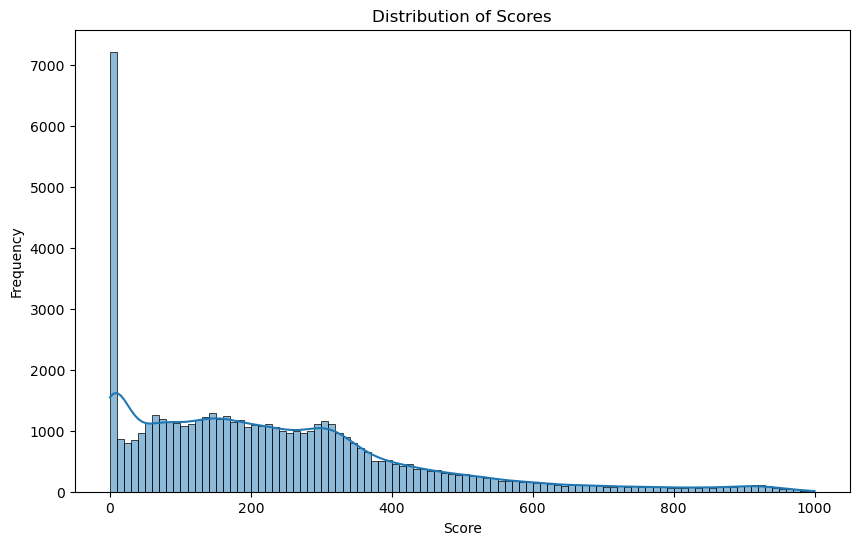

In [91]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming df_scores is your Spark DataFrame
df_scores_pandas = df_scores.select("score").toPandas()

# Plot the distribution of scores with more bins
plt.figure(figsize=(10, 6))
sns.histplot(df_scores_pandas["score"], bins=100, kde=True)  # Increase the number of bins to 100
plt.title("Distribution of Scores")
plt.xlabel("Score")
plt.ylabel("Frequency")
plt.show()

# Save Model

In [92]:
torch.save(final_model.state_dict(), "/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/sectionals_lstm_20250426.pt")

# Load Model

In [94]:
# Retrieve the best parameters from the study
best_params = study.best_trial.params
print(best_params)

{'dropout': 0.7997257360718246, 'hidden_size': 128, 'lr': 0.003481825508715826, 'num_layers': 3}


In [95]:
model = HorseTimeSeriesLSTM(input_size=6, hidden_size=128, num_layers=3, dropout=0.2)
model.load_state_dict(torch.load("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/models/LSTM/sectionals_lstm_20250426.pt"))
model.to(device)
model.eval()

/tmp/ipykernel_1720351/4265912569.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/home/exx/myCode/horse-racing/FoxRiverAIRacing/data/m

HorseTimeSeriesLSTM(
  (lstm): LSTM(6, 128, num_layers=3, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (head): Linear(in_features=128, out_features=1, bias=True)
  (projection): Linear(in_features=128, out_features=16, bias=True)
)

alter table horse_scores_lstm_gps
add CONSTRAINT horse_gps_lstm_id_key UNIQUE (horse_id);

CREATE INDEX idx_horse_gps_lstm ON public.horse_scores_lstm_gps USING btree (horse_id);


### MSE or MAE on Unscaled Values, e.g.m “actual seconds"

In [105]:
# Suppose you have your trained model and your scaler_y from training:

# 1) Get predicted values on the test set (scaled):
scaled_preds = []
scaled_truth = []

for X_batch, y_batch in test_loader:
    X_batch = X_batch.to(device)
    # forward pass
    pred_batch, _ = model(X_batch)
    # Move back to numpy
    pred_batch_np = pred_batch.cpu().detach().numpy()
    scaled_preds.append(pred_batch_np)
    scaled_truth.append(y_batch.numpy())

scaled_preds = np.concatenate(scaled_preds, axis=0)
scaled_truth = np.concatenate(scaled_truth, axis=0)

# 2) Invert the transform (assuming a MinMaxScaler or StandardScaler)
unscaled_preds = scaler_y.inverse_transform(scaled_preds.reshape(-1, 1)).flatten()
unscaled_truth = scaler_y.inverse_transform(scaled_truth.reshape(-1, 1)).flatten()

# 3) Compute MSE/MAE in real units:
mse_unscaled = np.mean((unscaled_preds - unscaled_truth)**2)
mae_unscaled = np.mean(np.abs(unscaled_preds - unscaled_truth))

print("MSE in real (seconds) domain:", mse_unscaled)
print("MAE in real (seconds) domain:", mae_unscaled)

MSE in real (seconds) domain: 70.96875
MAE in real (seconds) domain: 3.6927075


In [106]:
import numpy as np
import torch

def evaluate_unscaled(model, test_loader, device, scaler_y):
    """
    1) Make predictions in the scaled domain over *all* batches.
    2) Inverse-transform the *entire* arrays back to real units.
    3) Compute & print MSE, RMSE, MAE in the real domain.
    """
    model.eval().to(device)
    all_preds_scaled  = []
    all_labels_scaled = []

    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            Xb = X_batch.to(device)
            pred_scaled_t, _ = model(Xb)                # (batch_size,)
            all_preds_scaled.append(pred_scaled_t.cpu().numpy())
            all_labels_scaled.append(y_batch.numpy())

    # Concatenate across all batches
    all_preds_scaled  = np.concatenate(all_preds_scaled, axis=0)   # (N_test,)
    all_labels_scaled = np.concatenate(all_labels_scaled, axis=0)  # (N_test,)

    # Inverse-transform the *full* arrays
    pred_unscaled  = scaler_y.inverse_transform(
                        all_preds_scaled.reshape(-1,1)
                     ).ravel()
    label_unscaled = scaler_y.inverse_transform(
                        all_labels_scaled.reshape(-1,1)
                     ).ravel()

    # Compute real-domain metrics
    mse  = np.mean((pred_unscaled - label_unscaled)**2)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(pred_unscaled - label_unscaled))

    print(f"Test set → MSE={mse:.4f}, RMSE={rmse:.4f}, MAE={mae:.4f}")
    return rmse, mae, pred_unscaled, label_unscaled, all_preds_scaled

# Call it like this:
rmse, mae, preds_sec, actual_sec, scaled_preds = evaluate_unscaled(
    final_model, test_loader, device, scaler_y
)

print(f"Final RMSE in real domain: {rmse:.3f}")
print(f"Final MAE  in real domain: {mae:.3f}")

Test set → MSE=70.9688, RMSE=8.4243, MAE=3.6927
Final RMSE in real domain: 8.424
Final MAE  in real domain: 3.693


In [107]:
rmse, mae, preds_sec, actual_sec, pred_scaled = evaluate_unscaled(final_model, test_loader, device, scaler_y)

print(f"RMSE in real domain: {rmse:.3f}")
print(f"MAE  in real domain: {mae:.3f}")

Test set → MSE=70.9688, RMSE=8.4243, MAE=3.6927
RMSE in real domain: 8.424
MAE  in real domain: 3.693


## Compare Baseline

In [108]:
y_train_unscaled = scaler_y.inverse_transform(y_train_scaled.reshape(-1, 1)).flatten()
y_val_unscaled   = scaler_y.inverse_transform(y_val_scaled.reshape(-1, 1)).flatten()
y_test_unscaled  = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
y_unscaled = all_pd["target"].values

In [109]:
pred_unscaled = scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

In [110]:
import numpy as np

def compute_mean_baseline_metrics(y_train_unscaled, y_test_unscaled):
    """
    1) Compute the mean finishing time on the training set.
    2) Create baseline predictions => the same mean time for every test row.
    3) Compute MSE, RMSE, and MAE in real (seconds) domain.
    """

    # 1) Mean finishing time from training set
    train_mean_time = np.mean(y_train_unscaled)

    # 2) Baseline predictions: fill every test sample with 'train_mean_time'
    baseline_pred = np.full_like(y_test_unscaled, train_mean_time)

    # 3) Metrics
    mse  = np.mean((baseline_pred - y_test_unscaled)**2)
    rmse = np.sqrt(mse)
    mae  = np.mean(np.abs(baseline_pred - y_test_unscaled))

    print(f"[Mean Baseline]")
    print(f"  Train mean time = {train_mean_time:.3f} seconds")
    print(f"  Test MSE  = {mse:.3f}")
    print(f"  Test RMSE = {rmse:.3f}")
    print(f"  Test MAE  = {mae:.3f}")

    return mse, rmse, mae

# EXAMPLE USAGE (assuming you already have unscaled arrays):
# y_train_unscaled = ...
# y_test_unscaled  = ...
# compute_mean_baseline_metrics(y_train_unscaled, y_test_unscaled)

In [111]:
# FIRST: invert them to get unscaled times:
y_train_unscaled = scaler_y.inverse_transform(y_train_scaled.reshape(-1,1)).ravel()
y_test_unscaled  = scaler_y.inverse_transform(y_test_scaled.reshape(-1,1)).ravel()

# THEN: call the baseline function:
compute_mean_baseline_metrics(y_train_unscaled, y_test_unscaled)

[Mean Baseline]
  Train mean time = 18.933 seconds
  Test MSE  = 286.278
  Test RMSE = 16.920
  Test MAE  = 13.058


(286.27822887659255, 16.91975853481936, 13.058015990951949)